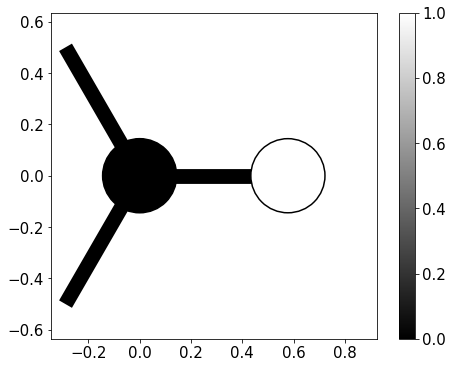

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.


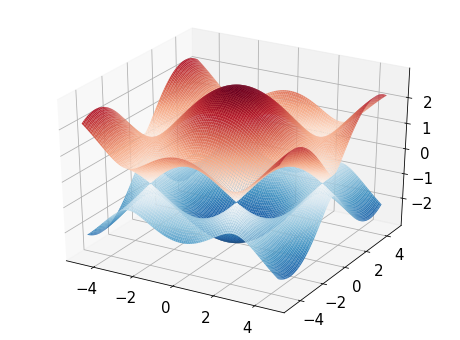

In [4]:
%run matplotlib_setup.ipy
from types import SimpleNamespace
from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import scipy.linalg as la
import kwant
from kwant.wraparound import wraparound, plot_2d_bands
def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice"""
    B = np.array(graphene.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)

def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
        momenta = np.linspace(-lim, lim, num_points)
        energies = []
        for kx in momenta:
            for ky in momenta:
                lattice_k = momentum_to_lattice([kx, ky])
                h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
                energies.append(np.linalg.eigvalsh(h))

        energies = np.array(energies).reshape(num_points, num_points, -1)
        emin, emax = np.min(energies), np.max(energies)
        kx, ky = np.meshgrid(momenta, momenta)
        fig = pyplot.figure()
        axes = fig.add_subplot(1, 1, 1, projection='3d')
        for band in range(energies.shape[-1]):
            axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                              cmap=matplotlib.cm.RdBu_r, vmin=emin, vmax=emax,
                              linewidth=0.1)

#Some helper functions to make the schematic look neat
def family_color(site): 
    if site.family == a: 
        return 0
    else: 
        return 1

def hopping_lw(site1,site2):
    return 0.1 if A in [site1.family,site2.family] else 0.05

graphene = kwant.lattice.general([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]],  #Lattice vectors \
                                      [[0,0],[1/np.sqrt(3),0]]) # Co-ordinates
a,b = graphene.sublattices

bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_graphene[graphene.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[graphene.neighbors(1)] = 1
kwant.plot(bulk_graphene,site_color=family_color,site_lw=0.01)
dispersion_2D(wraparound(bulk_graphene).finalized())

In [5]:
Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                               [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]) # Coordinates

def get_width(N=7):
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1]+0.01

def make_1D_zigzag(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    syst[Zigzag.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N)),(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    return syst